In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [35]:
df = pd.read_csv('/workspaces/machine-learning-zoomcamp-homework/03-classification/WA_Fn-UseC_-Telco-Customer-Churn.csv')
 
df.columns = df.columns.str.lower().str.replace(' ', '_')
 
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
 
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
 
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
 
df.churn = (df.churn == 'yes').astype(int)

In [36]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
 
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values
 
del df_train['churn']
del df_val['churn']
del df_test['churn'] 

In [37]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
 
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [38]:
dv = DictVectorizer(sparse=False)
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
 
model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [39]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
 
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

### Accuracy and Dummy Model

In [40]:
len(y_val)

1409

In [41]:
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [42]:
1132/1409

0.8034066713981547

In [43]:
from sklearn.metrics import accuracy_score

In [44]:
thresholds = np.linspace(0,1,21)

scores= []

for t in thresholds:
    score = accuracy_score(y_val,y_pred>=t)
    print('%.2f => %.3f' % (t,score))
    scores.append(score)

0.00 => 0.274
0.05 => 0.509
0.10 => 0.591
0.15 => 0.667
0.20 => 0.710
0.25 => 0.737
0.30 => 0.760
0.35 => 0.772
0.40 => 0.785
0.45 => 0.793
0.50 => 0.803
0.55 => 0.801
0.60 => 0.795
0.65 => 0.786
0.70 => 0.765
0.75 => 0.744
0.80 => 0.735
0.85 => 0.726
0.90 => 0.726
0.95 => 0.726
1.00 => 0.726


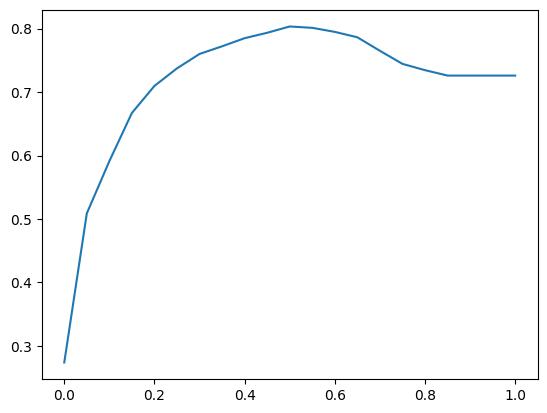

In [45]:
plt.plot(thresholds,scores)

In [46]:
from collections import Counter

In [47]:
Counter(y_pred>=0.5)

Counter({np.False_: 1098, np.True_: 311})

### Confusion Table

In [48]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [49]:
t = 0.5
predict_positive = (y_pred >=t)
predict_negative = (y_pred < t)

In [50]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [51]:
confusion_matrix = np.array([
    [tn,fp],
    [fn,tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [52]:
(confusion_matrix/confusion_matrix.sum()).round(3)

array([[0.654, 0.072],
       [0.125, 0.149]])

### Precision and Recall

##### precision - how many positive predictions are correct
##### recall - how many correctly identyfied  positive examples

In [53]:
(tp+tn)/(tp+tn+fp+fn)

np.float64(0.8034066713981547)

In [54]:
p = tp / (tp +fp)
p

np.float64(0.6752411575562701)

In [55]:
r = tp / (tp+fn)
r

np.float64(0.5440414507772021)

### ROC - curves

In [56]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5440414507772021)

In [57]:
fpr = fp / (fp +tn)
fpr

np.float64(0.09872922776148582)

In [58]:
scores = []

thresholds = np.linspace(0,1,100)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >=t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t,tp,fp,fn,tn))

    

In [60]:
columns = ['threshold','tp','fp','fn','tn']
df_scores = pd.DataFrame(scores,columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp+df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp+df_scores.tn)

df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.000000,386,1023,0,0,1.000000,1.000000
10,0.101010,366,550,20,473,0.948187,0.537634
20,0.202020,333,353,53,670,0.862694,0.345064
30,0.303030,283,234,103,789,0.733161,0.228739
40,0.404040,249,164,137,859,0.645078,0.160313
50,0.505051,208,100,178,923,0.538860,0.097752
60,0.606061,147,49,239,974,0.380829,0.047898
70,0.707071,68,15,318,1008,0.176166,0.014663
80,0.808081,7,0,379,1023,0.018135,0.000000
90,0.909091,0,0,386,1023,0.000000,0.000000


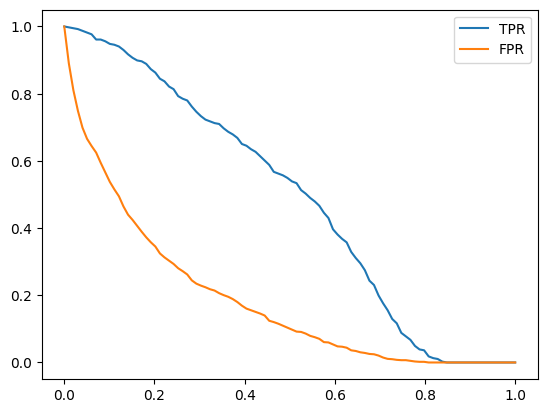

In [62]:
plt.plot(thresholds,df_scores['tpr'],label='TPR')
plt.plot(thresholds,df_scores['fpr'],label='FPR')
plt.legend()

### random model

In [67]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))

((y_rand>=0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [70]:
def tpr_ftr_dataframe(y_val, y_pred):


    scores = []

    thresholds = np.linspace(0,1,100)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >=t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t,tp,fp,fn,tn))

    columns = ['threshold','tp','fp','fn','tn']
    df_scores = pd.DataFrame(scores,columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp+df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp+df_scores.tn)

    return df_scores

In [71]:
df_rand =tpr_ftr_dataframe(y_val,y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.000000,386,1023,0,0,1.000000,1.000000
10,0.101010,347,922,39,101,0.898964,0.901271
20,0.202020,307,820,79,203,0.795337,0.801564
30,0.303030,273,722,113,301,0.707254,0.705767
40,0.404040,235,619,151,404,0.608808,0.605083
50,0.505051,201,514,185,509,0.520725,0.502444
60,0.606061,160,399,226,624,0.414508,0.390029
70,0.707071,118,295,268,728,0.305699,0.288368
80,0.808081,73,196,313,827,0.189119,0.191593
90,0.909091,34,92,352,931,0.088083,0.089932


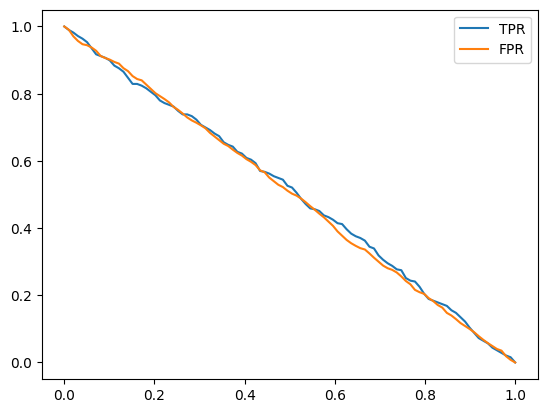

In [73]:
plt.plot(df_rand.threshold,df_rand['tpr'],label='TPR')
plt.plot(df_rand.threshold,df_rand['fpr'],label='FPR')
plt.legend()

### ideal model

In [80]:
num_neg =(y_val == 0).sum()
num_pos =(y_val == 1).sum()
num_neg,num_pos

(np.int64(1023), np.int64(386))

In [82]:
y_ideal = np.repeat([0,1],[num_neg,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [83]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [84]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [85]:
((y_ideal_pred>=0.726) == y_ideal).mean()

np.float64(1.0)

In [86]:
df_ideal =tpr_ftr_dataframe(y_ideal,y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.000000,386,1023,0,0,1.000000,1.000000
10,0.101010,386,880,0,143,1.000000,0.860215
20,0.202020,386,738,0,285,1.000000,0.721408
30,0.303030,386,596,0,427,1.000000,0.582600
40,0.404040,386,454,0,569,1.000000,0.443793
50,0.505051,386,311,0,712,1.000000,0.304008
60,0.606061,386,169,0,854,1.000000,0.165200
70,0.707071,386,27,0,996,1.000000,0.026393
80,0.808081,271,0,115,1023,0.702073,0.000000
90,0.909091,129,0,257,1023,0.334197,0.000000


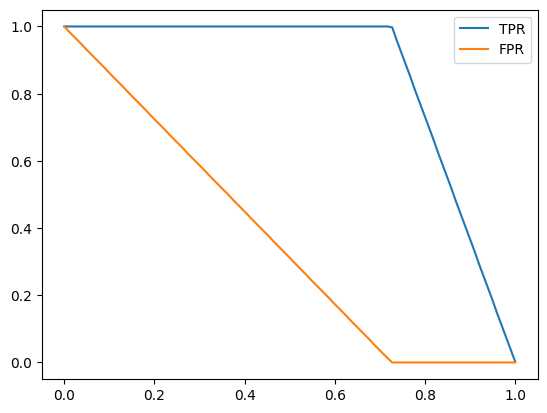

In [87]:
plt.plot(df_ideal.threshold,df_ideal['tpr'],label='TPR')
plt.plot(df_ideal.threshold,df_ideal['fpr'],label='FPR')
plt.legend()

### Putting everything together

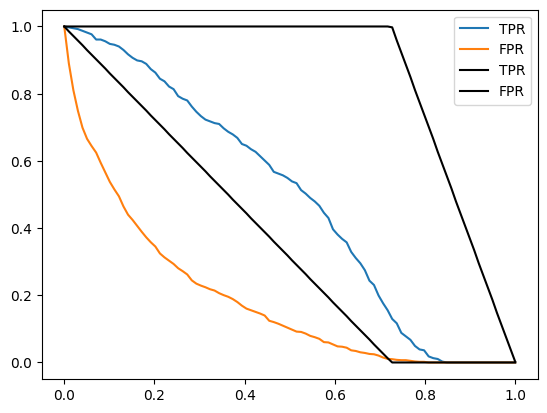

In [90]:
plt.plot(df_scores.threshold,df_scores['tpr'],label='TPR')
plt.plot(df_scores.threshold,df_scores['fpr'],label='FPR')

# plt.plot(df_rand.threshold,df_rand['tpr'],label='TPR')
# plt.plot(df_rand.threshold,df_rand['fpr'],label='FPR')

plt.plot(df_ideal.threshold,df_ideal['tpr'],label='TPR',color='black')
plt.plot(df_ideal.threshold,df_ideal['fpr'],label='FPR',color='black')

plt.legend()

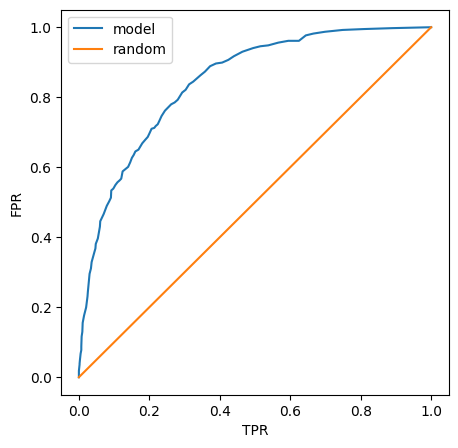

In [96]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr,df_scores.tpr,label='model')
plt.plot([0,1],[0,1],label = 'random')
#plt.plot(df_rand.fpr,df_rand.tpr,label='random')
#plt.plot(df_ideal.fpr,df_ideal.tpr,label='ideal')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.legend()

In [97]:
from sklearn.metrics import roc_curve

In [100]:
fpr,tpr,thresholds = roc_curve(y_val,y_pred)

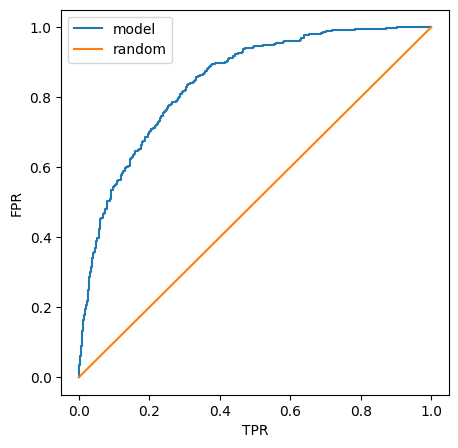

In [101]:
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,label='model')
plt.plot([0,1],[0,1],label = 'random')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.legend()